<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

# Uncertainty in Ensemble Learners

#### Zhikai (Ben) Zhong, Undergraduate Student, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/benzhong)

#### Supervised by:

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### For PGE 376

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)




## Loading the required libraries
The following code loads the required libraries.

In [1]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn import metrics                                 # measures to check our models
from sklearn.tree import export_graphviz                    # graphical visualization of trees
from sklearn.preprocessing import StandardScaler            # standardize variables to mean of 0.0 and variance of 1.0

from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor               # bagging tree method
from sklearn.ensemble import RandomForestRegressor          # random forest method
from sklearn.ensemble import ExtraTreesRegressor            # extra trees method
from sklearn.ensemble import GradientBoostingRegressor      # gradient boosting method
from sklearn.ensemble import AdaBoostRegressor              # adaboosting method
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information

import random

import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call

from pylab import *
from scipy.stats import norm

from tqdm.notebook import tqdm
import time

import numpy as np
import scipy.stats

from ipywidgets import interact, interactive, fixed, interact_manual                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

## Defining Functions
There are two functions: 
1. **create_df (model, X_test, y_test)**


2. **plot_df (df, percentile)**

The **create_df** function creates a pandas dataframe where each row represents a testing sample, first columns is the true value of the testing sample, and every column after represents the prediction of each estimators in a ensemble learner.

The **plot_df** function takes in the aforementioned dataframe and returns an accuracy plot. 


In [65]:
test_size=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
percentile=np.arange(0,100,2)

#a function that creates a dataframe where each column contains an estimator's prediction
#with the first column being the true value
#and each row corresponds to each sample in the testing set
def create_df(Model,X_test,y_test):                         
    df=pd.DataFrame(y_test)                                 #creating the dataframe with true value in it
    df.columns.values[0] = "True_Value"
    df=df.reset_index(drop=True)
    count=0
    for i in Model.estimators_:                             #looping over the model's individual estimators(trees)  
        count+=1
        Df=pd.DataFrame(i.predict(X_test))
        Df.columns=['L='+str(count)]    
        df=pd.concat([df, Df], axis=1)                      #add each prediction to a new column 
    return df

#a function that takes in the aforementioned dataframe
#and plots an accuracy plot for the ensemble learner
def plot_df(df,percentile):
    m,n=df.shape
    percentile=percentile/100
    percentage=[]
    for i in range(0,m):                                    #looping over each row        
        find=False; count=0
        True_value=df.iloc[i,0]
        row=df.iloc[i,1:]
        while find==False and count<len(percentile):
            for percent in percentile:                      #looping over each row
                down=np.percentile(row,(1-percent)/.02); up=np.percentile(row, 100-(1-percent)/.02)
                if True_value<=up and True_value>=down:     #finding the percentile of true value among the estimated values
                    percentage=np.append(percentage,percent)
                    find=True
                    break
                else:
                    count+=1
    lst=[]
    for i in percentile:                                    #calculating % samples in each CI
        s=sum([1 for x in percentage if x <=i])
        lst=np.append(lst,s)
    
    lst/=m                 
    x=np.linspace(0,1,len(lst))
    y=x
    score=round(1-2*sum(abs((np.array(lst)-x)))/len(x),3)
    #plotting accuracy plot
    plt.plot(x,y,'black'); plt.text(.5,.15,'Precision:'+str(score),bbox={'facecolor':'grey','alpha':0.2,'pad':10}); 
    plt.plot(x,np.array(lst),'ro')
    plt.xlabel('Probability Interval', fontsize=14); plt.ylabel('Percentage of Samples ', fontsize=14); 
    plt.title('Accuracy Plot', fontsize=20)
    fill([0,1,1,0], [0,1,1,1], 'black', alpha=0.1, edgecolor='black')

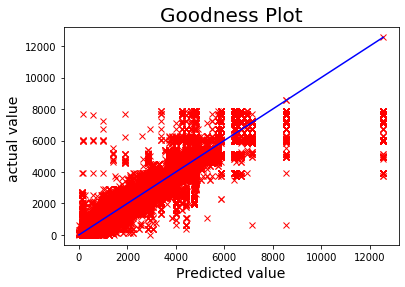

## Preping The Data

### Loading dataset

The dataset is composed of porosity, brittleness, permeability and other positive variables. 

Therefore we assume all the negative values to be 0 due to inaccuracy in measurements. 

In [55]:
my_data = pd.read_csv("unconv_MV.csv") 
num = my_data._get_numeric_data() # get the numerical values
num[num < 0] = 0  #filtering out unrealistic values that are less than 0

### Train/Test Split
We split the data into training and testing data for the purpose of cross validation.

We use the command train_test_split from sklearn. 

We set the **random_state** variable to 0 (or any other integer) to make sure our results are reproducible. 


In [56]:
feature_cols = ['Por',
                'Brittle',
                'LogPerm',
                'AI',
                'TOC',
                'VR'
               ]
X=my_data[feature_cols]
y=my_data.Production

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0) #50% Testing 50% Training

## Looking At The Model

### Building The Model

In this example, we use randomforest regressor to predict the intial gas production with several features.

We are going to create a model and then cross validate it with the testing data and give it a regression score.

The best score is 1.

In [57]:
original_model=RandomForestRegressor(n_estimators=300, random_state=0, min_samples_leaf=1,oob_score=True)
original_model=original_model.fit(X_train,y_train)
original_df=create_df(original_model,X_test,y_test)
explained_variance_score(y_test, original_model.predict(X_test)) 
#See the correlation between our model and the testing data
#We have a pretty good score, meaning our model does a good job predicitng gas production
#However, does our model have an accurate uncertainty model?


0.9436744501278863

### Individual Estimators

Ensemble learners are consisted of many individual estimators (trees). Each individual estimators will make a prediction and we yield the final prediction from the results of those estimators predictions.

We can have each individual tree make a prediction and plot their distribution in a histogram.

Ideally, this should be a normal distribution. 

We need to be able to offer a confidence interval for our prediction.

Ideally, X% of the testing samples should fall into the confidence interval of X%.
* For instance, 95% of times, the testing sample should fall into the model's 95% confidence interval

Text(0.5, 1.0, 'Prediction Distribution')

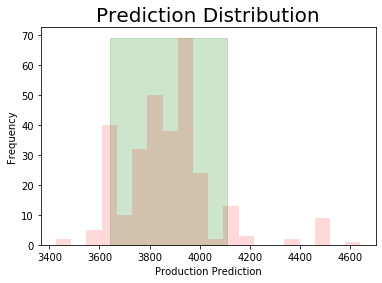

In [6]:
preds=original_df.iloc[0,1:]                                 # For example, let's pick the 1st testing sample to graph
height, bins, patches=plt.hist(preds,alpha=.15,bins=20,color='r')
ci = norm(*norm.fit(preds)).interval(0.8)               # Confidence interval of 90%
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.2) 
plt.xlabel('Production Prediction')
plt.ylabel('Frequency')
plt.title('Prediction Distribution', fontsize=20)


## Uncertainty Modeling

### Plotting Accuracy Plot

Use the previously defined functions to determine whether the model is overfitting or underfitting.

We are going to plot the proportion of true data within [10,20,30,40,50,60,70,80,90]% interval. 

If the datapoints land in the shaded area, that means the model is **accurate but imprecise**.

If the datapoints land on the line, that means the model is **accurate and precise**.

If the datapoints land in the unshaded area, that means the model is **inaccurate and imprecise**.

#### How Test Size Could Affect Uncertainty Modeling

Remember before creating the regression model, we had to split our dataset into training and testing datasets.

Because the ratio of testing and training sets can different depending on how one sets it, it could potentially affect our uncertainty model.

Here we are going to examine how different test size from .1 to .9 of the whole dataset could affect our uncertainty model.

In [7]:
def test(i,percentile):
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=i, random_state=0)
    model=RandomForestRegressor(n_estimators=300, random_state=0, min_samples_leaf=1)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    m,n=df.shape
    percentile=percentile/100
    percentage=[]
    for i in range(0,m):
        find=False
        count=0
        True_value=df.iloc[i,0]
        row=df.iloc[i,1:]
        while find==False and count<len(percentile):
            for percent in percentile: 
                down=np.percentile(row,(1-percent)/.02); up=np.percentile(row, 100-(1-percent)/.02)
                if True_value<=up and True_value>=down:
                    percentage=np.append(percentage,percent)
                    find=True
                    break
                else:
                    count+=1
    lst=[]
    for i in percentile:
        s=sum([1 for x in percentage if x <=i])
        lst=np.append(lst,s)
    lst/=m                 
    return lst

def update(i=0):
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    x = np.linspace(0,1,5)
    y = x
    #plotting accuracy plot
    plt.plot(x, y, 'black')
    plt.plot(np.array(percentile)/100,lst[int(i*10)-1],'ro')
    plt.xlabel('Probability Interval', fontsize=14)
    plt.ylabel('Percentage of Samples ', fontsize=14)
    plt.title('Accuracy Plot', fontsize=20)
    fill([0,1,1,0], [0,1,1,1], 'black', alpha=0.1, edgecolor='black')
    plt.show()



In [8]:
lst=[test(i,percentile) for i in tqdm(test_size)]

In [9]:
interact(update, i = widgets.FloatSlider(value=.1,
                                               min=.1,
                                               max=.9,
                                               step=.1,
                                        description='Test Size',
                                        continuous_update=True))
#According to the graph below, the model is underfitting because the data points all landed in the shaded zone
#For example, looking at test size=.5, at 50% CI, more than 60% of the testing samples fell into their corresponding CI
#This means that the model is underfitting: the CI is too wide to be precise.
#For consistency, we are going to set our test size to .5 

interactive(children=(FloatSlider(value=0.1, description='Test Size', max=0.9, min=0.1), Output()), _dom_class…

<function __main__.update(i=0)>

### Improving The Uncertainty Model
The hypothesis is that we can improve the precision of our model by simplifying the each individual estimators of an ensembler learner. 

This could be done in many ways simply by adjusting the hyperparameters of an ensemble learner.

Here are two common hyperparameters we can adjust:

**1. min_samples_leaf**

This controls the minimum sample of a leaf/leaves. When splitting, only nodes that contains more samples than the threshold would be split into a leaf.

**2. max_features**

This controls the number of features to be considered when splitting. A tree would only split/grow by considering the amount of variables at the threshold of this variable.

**3. max_depth**

This controls the maximum depth an individual estimator (tree) will grow. Nodes will stop splitting once the tree depth has grown to this value.

**4. max_leaf_nodes**

This controls the maximum leaf nodes when trees are grown. The best nodes are kept, in terms of relative reduction in impurity.
#### Hyperparameter 1, 3, 4 affects the size of each estimator (tree), whereas 2 does not.

#### Max Feature
There are 6 features in this dataset. We are going to adjust the maximum number of features when splitting trees to see how that is going to affect the uncertainty model.

When restricting the max features, all the trees are still fully grown. 


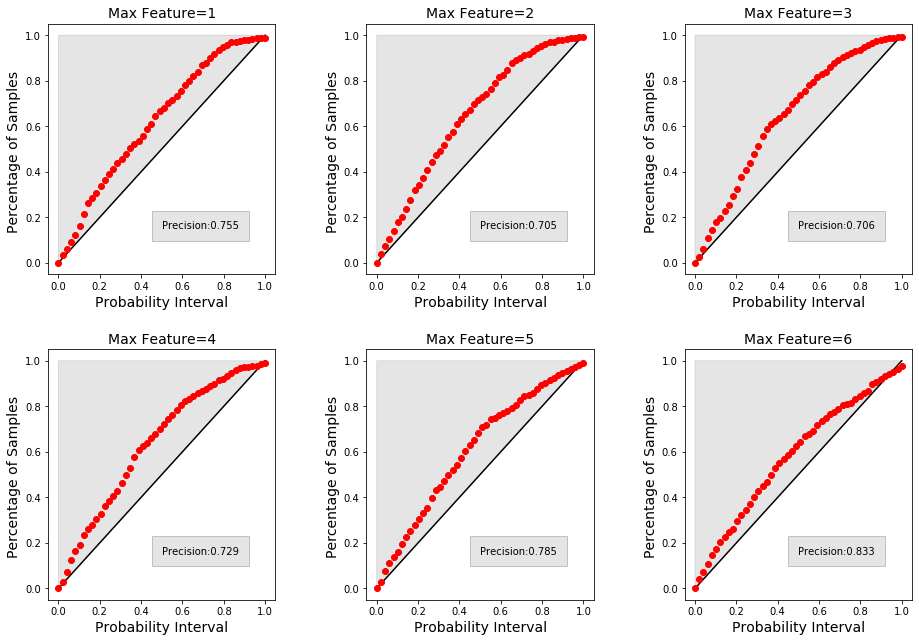

In [10]:
max_features=[1,2,3,4,5,6]
for i in tqdm(max_features):
    plt.subplot(2, 3, i)
    model=RandomForestRegressor(n_estimators=300, random_state=0, 
                                #random_state sets the random seed to ensure we get the same result everytime
                                min_samples_leaf=1, oob_score=True,
                               max_features=i)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Feature='+str(i),fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)
#The results show that max features don't have a lot of effect on improving the uncertainty model

#### Minimum Sample Leaf

Now we are going to explore how minimum leaves are going to affect uncertainty modeling. 

This **min_samples_leaf** restrict the minimum number of leaves on a leaf node. Therefore all the trees will be pruned to a certain degree. 

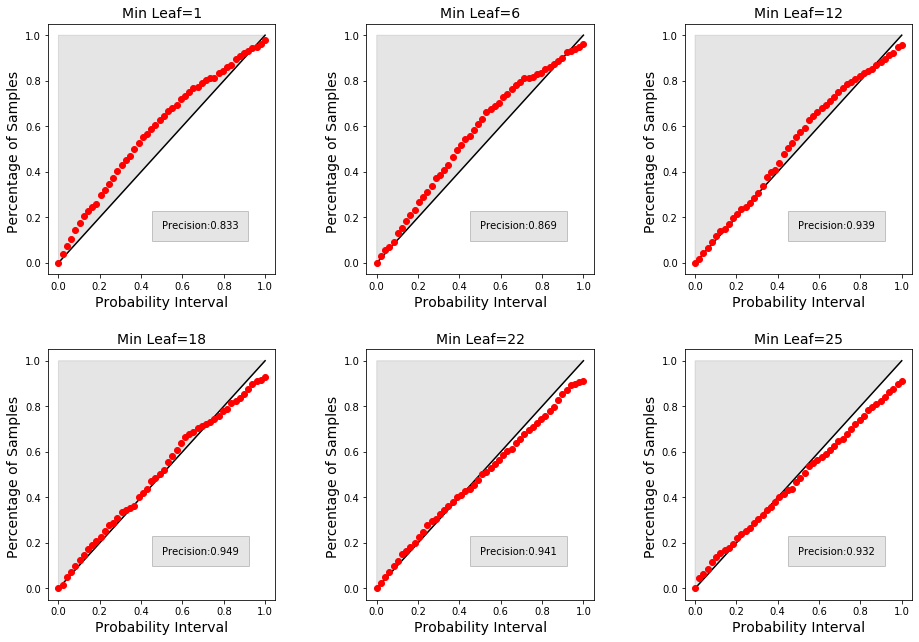

In [11]:
min_leaf=[1,6,12,18,22,25]
index=1
for i in tqdm(min_leaf):
    plt.subplot(2, 3, index)
    model=RandomForestRegressor(n_estimators=300, random_state=0, 
                                min_samples_leaf=i, oob_score=True,max_features='auto'
                               )
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Min Leaf='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)
#As you can see from the graphs below, tree complexity affects the uncertainty model
#When min leaf is 1, the model is underfitting
#When min leaf gets above 20, the model starts to overfit
#The most optimal setting would probably be 20

#### Maximum Depth

The default value is None. When it's none, all the trees will be fully grown. 

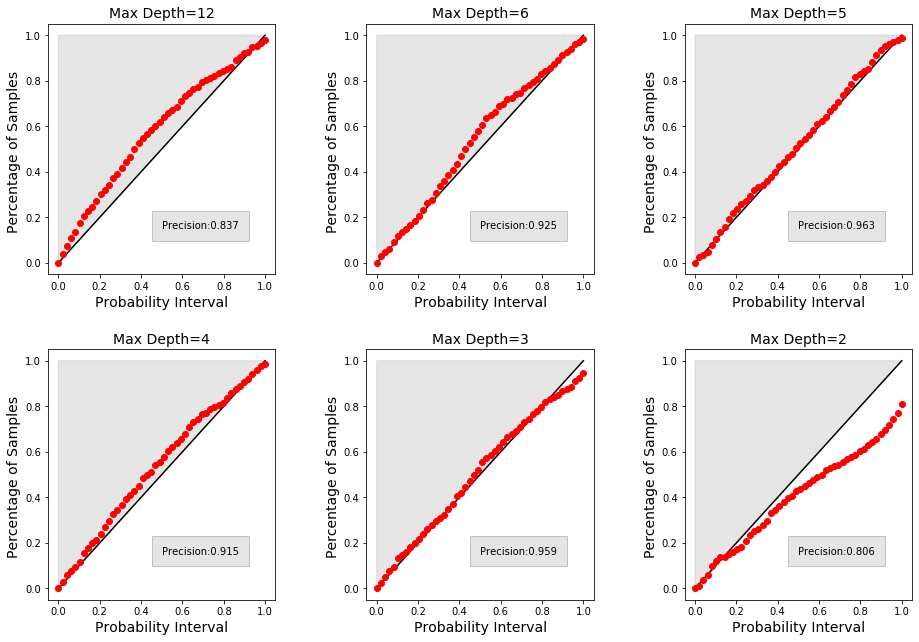

In [12]:
max_depth=[12,6,5,4,3,2]
index=1
for i in tqdm(max_depth):
    plt.subplot(2, 3, index)
    model=RandomForestRegressor(n_estimators=300, random_state=0,
                              max_depth=i)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Depth='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

#As you can see from the graphs below, tree complexity affects the uncertainty model
#When max_depth is 2, the model is inaccurate and imprecise
#When max_depth gets above 5, the model starts to underfit
#The most optimal setting would probably be 5. 

#### Max Leaf Nodes

The default value is None. When it's none, all the trees are fully grown.

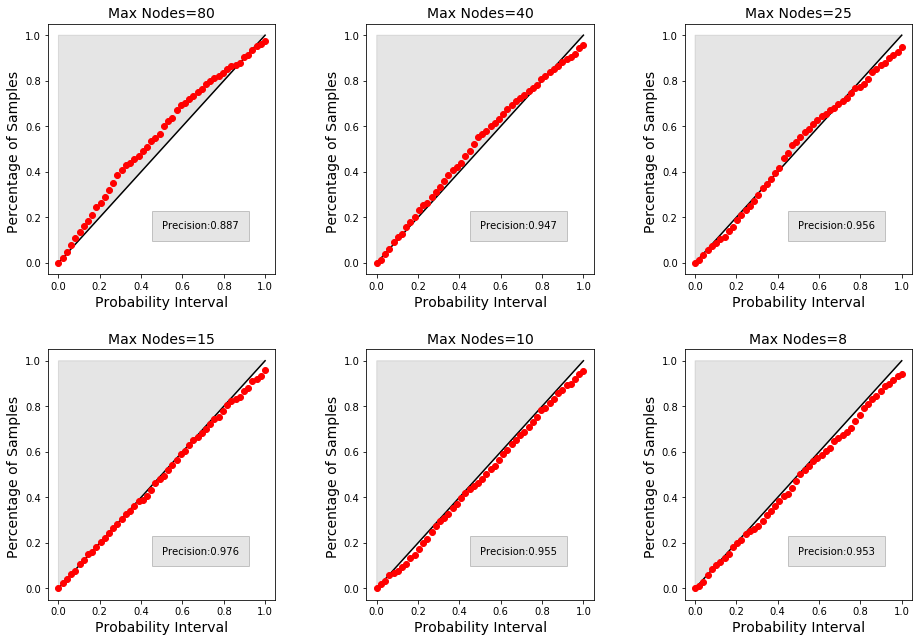

In [13]:
max_nodes=[80,40,25,15,10,8]
index=1
for i in tqdm(max_nodes):
    plt.subplot(2, 3, index)
    model=RandomForestRegressor(n_estimators=300, random_state=42,
                              max_leaf_nodes=i)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Nodes='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

#As you can see from the graphs below, tree complexity affects the uncertainty model
#When max_leaf_nodes is 5, the model is inaccurate and imprecise
#When max_leaf_nodes gets above 10, the model starts to underfit
#The most optimal setting would probably be 9. 

### Conclusion

**Size of the trees affects uncertainty modeling whereas restraining splitting criterias does not seem to help with uncertainty modeling**

#### Checking Model Performance

Since we found out that min_samples_leaf's optimal value is 20. We can build another model with this hyperparameter setting and see how well the model can perform.

Because  we increased the minimum samples per leaf, we decreased the complexity of the model and this trade-off could result in a poorer fit. 

In [14]:
improved_model=RandomForestRegressor(n_estimators=100, random_state=0, max_leaf_nodes=30,oob_score=True)
improved_model=improved_model.fit(X_train,y_train)
improved_df=create_df(improved_model,X_test,y_test)

original_model=RandomForestRegressor(n_estimators=100, random_state=0, min_samples_leaf=1,oob_score=True)
original_model=original_model.fit(X_train,y_train)
original_df=create_df(original_model,X_test,y_test)

print('Model score original', explained_variance_score(y_test, original_model.predict(X_test)))
print('Model score adjusted', explained_variance_score(y_test, improved_model.predict(X_test)))

#When simplifying our model, we sacrificed some of our accuracy as seen by the decrease in the correlation score
#0.8 is still an acceptable correlation

Model score original 0.9445661230775801
Model score adjusted 0.9353188556042623


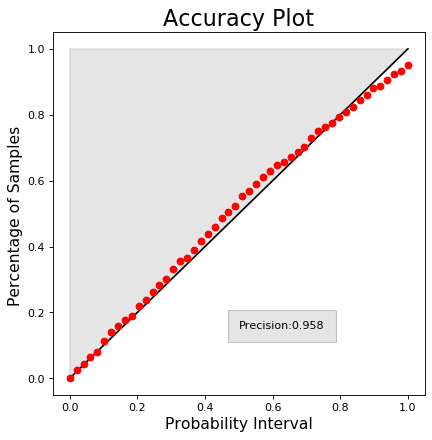

In [15]:
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plot_df(improved_df,percentile)
#Now our uncertainty model is more or less on the line 
#We improved the precision of our model by sacrificing some of our accuracy 


#### Change in Prediction Distribution 

Now let's look at the prediction distribution again.

Adjusted predcition distribution is a lot more normal than the original model.

In [16]:
def compare(n,confidence): 
    #plt.clf()
    fig, (ax1,ax2)=plt.subplots(1,2)
    
    preds=original_df.iloc[n,1:]; improved_pred=improved_df.iloc[n,1:]
    preds_true=float(original_df.iloc[n,0]); improved_true=float(improved_df.iloc[n,0])
    # For example, let's pick the nth testing sample to graph
    
    height, bins, patches=ax1.hist(preds, alpha=.25, bins=15, color='r'); height2, bins2, patches2=ax2.hist(improved_pred, alpha=.25, bins=15, color='r')
    ax1.axvline(preds_true, color='k', linewidth=1,label='True Value'); ax2.axvline(improved_true, color='k', linewidth=1,label='True Value')
    
    ylim1=ax1.get_ylim(); xlim1=ax1.get_xlim(); xlim2=ax2.get_xlim(); ylim2=ax2.get_ylim()
    xlim=[min(np.append(xlim1,xlim2)),max(np.append(xlim1,xlim2))]; ylim=[min(np.append(ylim1,ylim2)),max(np.append(ylim1,ylim2))]
    
    #normal CI
    #ci1 = norm(*norm.fit(preds)).interval(confidence)   
    #ci2 = norm(*norm.fit(improved_pred)).interval(confidence) 
    
    #quantile CI
    ci1=[np.percentile(preds,(1-confidence)*50), np.percentile(preds, 100-(1-confidence)*50)]
    ci2=[np.percentile(improved_pred,(1-confidence)*50), np.percentile(improved_pred, 100-(1-confidence)*50)]
    
    ax1.fill_betweenx([0, height.max()], ci1[0], ci1[1], color='g', alpha=0.2)  
   
               
    ax2.fill_betweenx([0, height2.max()], ci2[0], ci2[1], color='g', alpha=0.2)
    
    ax2.set(title='Adjusted',xlabel='Production Prediction',ylabel='Frequency')
    ax2.set_xlim(xlim); ax2.set_ylim(ylim)
    ax1.set(title='Original',xlabel='Production Prediction',ylabel='Frequency')
    ax1.set_xlim(xlim); ax1.set_ylim(ylim)
    
    fig.set_figheight(8); fig.set_figwidth(15)
    
    ax1.legend();ax2.legend()
    plt.show()

In [ ]:
l = widgets.Text(value='Estimators distribution before and after adjustment',layout=Layout(width='950px', height='30px'))

#index number of the sample we are plotting
n = widgets.IntSlider(min=0, max = len(improved_df)-1, value = 0, step = 1, description = '$N$th sample',orientation='horizontal',continuous_update=False, layout=Layout(width='400px', height='20px'))
n.style.handle_color = 'gray'

#confidence interval we are plotting
confidence = widgets.FloatSlider(min=0.05, max = .96, value = 0.7, step = .05, description = '$Confidence$',orientation='horizontal', continuous_update=False, layout=Layout(width='400px', height='20px'))
confidence.style.handle_color = 'green'

ui = widgets.HBox([n,confidence],) 
ui2 = widgets.VBox([l,ui],)

interactive_plot = widgets.interactive_output(compare, {'n':n, 'confidence': confidence})
interactive_plot.clear_output(wait = True)

display(ui2, interactive_plot)  

## Uncertainty Modeling With Other Ensemble Methods

### Extra Trees 

After focusing on Random Forest Regressor, we can take a look at Extra Trees Regressor, which is very similar to Random Forest.

#### Minimum Sample Leaf
We are going to check how min_leaf affects the uncertainty model of ExtraTreesRegressor


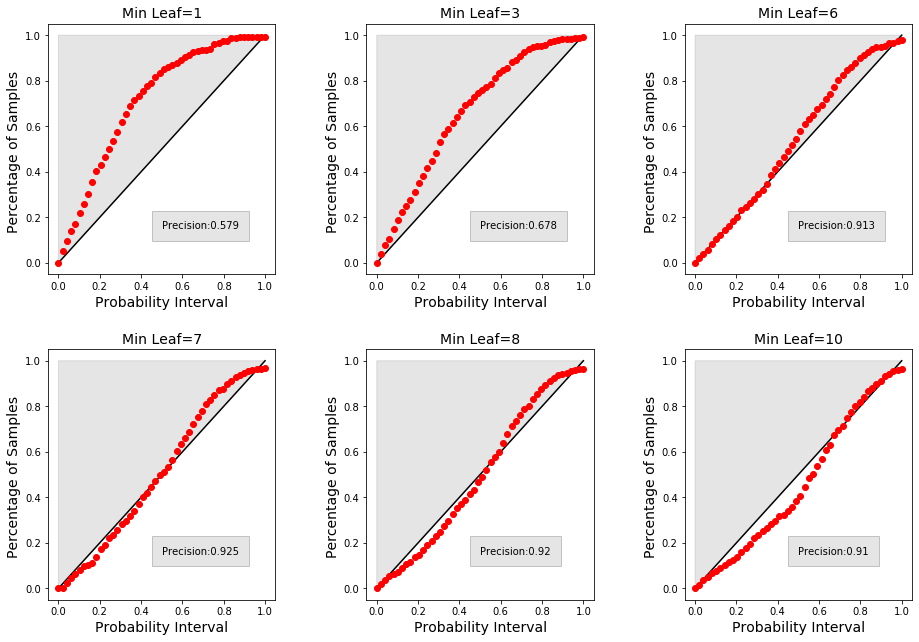

In [18]:
min_leaf=[1,3,6,7,8,10]
index=1
for i in min_leaf:
    plt.subplot(2, 3, index)
    model=ExtraTreesRegressor(n_estimators=300, random_state=0, 
                                min_samples_leaf=i, max_features='auto',
                              bootstrap=True,oob_score=True
                               )
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Min Leaf='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)
#As we can see ExtraTreesRegressor is a little different from RandomForestRegressor

#### Max Depth
Now check how max_depth affects the uncertainty model

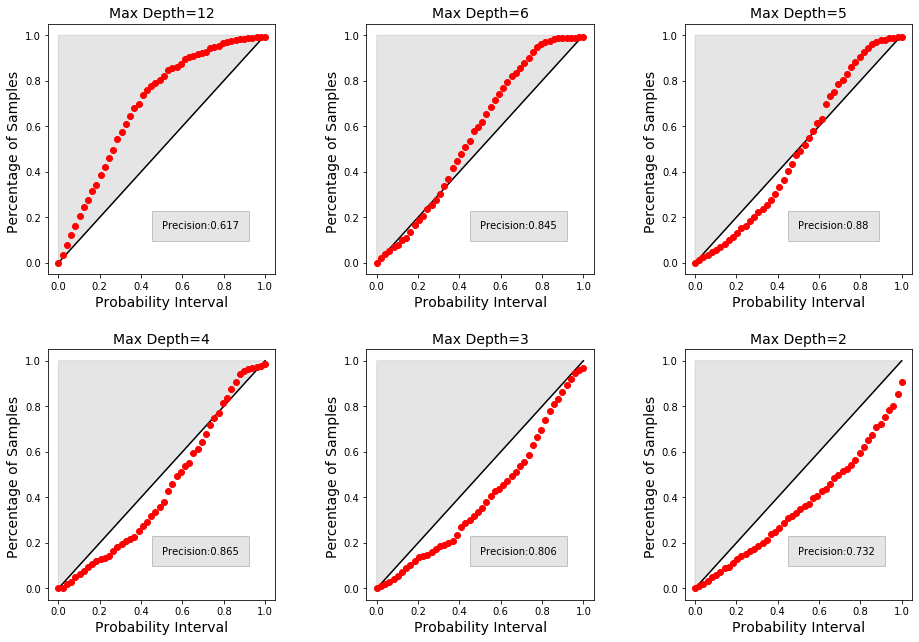

In [19]:
max_depth=[12,6,5,4,3,2]
index=1
for i in max_depth:
    plt.subplot(2, 3, index)
    model=ExtraTreesRegressor(n_estimators=300, random_state=0,
                                max_depth=i)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Depth='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

#As you can see from the graphs below, tree complexity affects the uncertainty model
#When max_depth is 2, the model is inaccurate and imprecise
#When max_depth gets above 5, the model starts to underfit
#The most optimal setting would probably be 5. 

#### Max Leaf Nodes

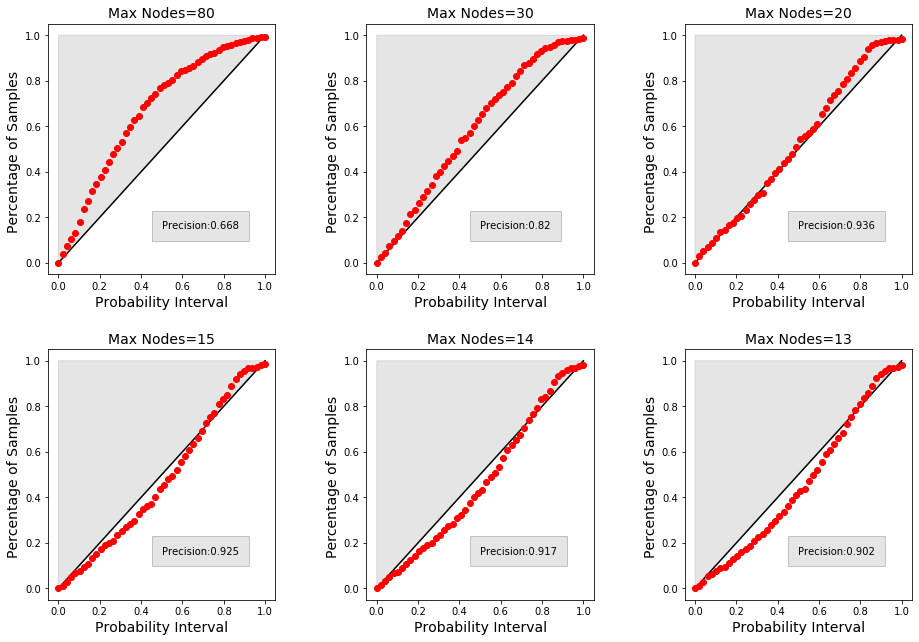

In [20]:
max_nodes=[80,30,20,15,14,13]
index=1
for i in tqdm(max_nodes):
    plt.subplot(2, 3, index)
    model=ExtraTreesRegressor(n_estimators=300, random_state=42,
                              max_leaf_nodes=i)
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Nodes='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

#As you can see from the graphs below, tree complexity affects the uncertainty model
#When max_leaf_nodes is 5, the model is inaccurate and imprecise
#When max_leaf_nodes gets above 10, the model starts to underfit
#The most optimal setting would probably be 9. 

In [21]:
improved_model=ExtraTreesRegressor(n_estimators=300, random_state=0, min_samples_leaf=7)
improved_model=improved_model.fit(X_train,y_train)
improved_df=create_df(improved_model,X_test,y_test)

original_model=ExtraTreesRegressor(n_estimators=300, random_state=0, min_samples_leaf=1)
original_model=original_model.fit(X_train,y_train)
original_df=create_df(original_model,X_test,y_test)
print('R2 before', explained_variance_score(y_test, original_model.predict(X_test)))
print('R2 after', explained_variance_score(y_test, improved_model.predict(X_test)))
#When simplifying our model, we sacrificed some of our accuracy as seen by the decrease in the correlation score
#0.8 is still an acceptable correlation

R2 before 0.9430501200750964
R2 after 0.8101425678517888


In [22]:
l = widgets.Text(value='Estimators distribution before and after adjustment',layout=Layout(width='950px', height='30px'))

#index number of the sample we are plotting
n = widgets.IntSlider(min=0, max = len(improved_df)-1, value = 0, step = 1, description = '$N$th sample',orientation='horizontal',continuous_update=False, layout=Layout(width='400px', height='20px'))
n.style.handle_color = 'gray'

#confidence interval we are plotting
confidence = widgets.FloatSlider(min=0.05, max = .96, value = 0.7, step = .05, description = '$Confidence$',orientation='horizontal', continuous_update=False, layout=Layout(width='400px', height='20px'))
confidence.style.handle_color = 'green'

ui = widgets.HBox([n,confidence],) 
ui2 = widgets.VBox([l,ui],)

interactive_plot = widgets.interactive_output(compare, {'n':n, 'confidence': confidence})
interactive_plot.clear_output(wait = True)

display(ui2, interactive_plot)  

Output()

### Boosting Methods

#### Plotting Accuracy Plot For Gradient Boost

Boosting has a different mechanism where the individual estimators are predicting loss, we will need to define a new function to create the dataframe we have been using.

In [23]:
def GB_plot(X_train,y_train,X_test,y_test,percentile,
           min_samples_leaf=1,max_depth=3,min_samples_split=2,n_estimators=200):
    df=pd.DataFrame(y_test)
    df=df.rename(columns={'Production':'True_Value'})
    df=df.reset_index(drop=True)
    # Set lower and upper quantile
    # Each model has to be separate
    m,n=df.shape
    percentage=[]
    for percent in percentile:
        UPPER_ALPHA = (1-(percent/100))/2+(percent/100)
        LOWER_ALPHA = 1-UPPER_ALPHA
        lower= GradientBoostingRegressor(loss="quantile",                   
                                         alpha=LOWER_ALPHA,
                                         random_state=0,
                                         min_samples_leaf=min_samples_leaf,
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         n_estimators=n_estimators)
        upper = GradientBoostingRegressor(loss="quantile",
                                          alpha=UPPER_ALPHA,
                                          random_state=0,
                                          min_samples_leaf=min_samples_leaf,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          n_estimators=n_estimators)
        lower.fit(X_train,y_train)
        upper.fit(X_train,y_train)
        count=0
        for i in range(0,m):
            True_value=df.iloc[i,0]
            #CI upper and lower bound is calculated here
            down=lower.predict(pd.DataFrame(X_test.iloc[i]).transpose())
            up=upper.predict(pd.DataFrame(X_test.iloc[i]).transpose())

            #determining if the true value falls within the CI
            if True_value<up and True_value>down:
                count+=1
        percentage=np.append(percentage,count/m)
    x = np.linspace(0,1,5)
    y = x
    plt.plot(x, y, 'black')
    plt.plot(np.array(percentile)/100,np.array(percentage),'ro')
    plt.xlabel('Probability Interval', fontsize=14)
    plt.ylabel('Percentage of Samples ', fontsize=14)
    plt.title('Accuracy Plot', fontsize=20)
    fill([0,1,1,0], [0,1,1,1], 'black', alpha=0.1, edgecolor='black')

#### Plotting Accuracy Plot

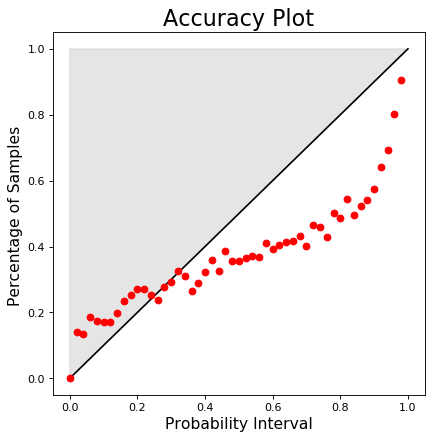

In [24]:
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
GB_plot(X_train,y_train,X_test,y_test,percentile,
       min_samples_leaf=10,max_depth=4,min_samples_split=10,
       n_estimators=300)

In [25]:
model2=GradientBoostingRegressor(n_estimators=300, random_state=0)
model2=model2.fit(X_train,y_train)

print('R2', explained_variance_score(y_test, model2.predict(X_test)))

R2 0.9598336270074659


In [26]:
#scrap code below

### Dataset Size And Uncertainty Modeling

The size of the dataset we used was 1000 rows. 

Real life dataset would be of many different sizes.

Because the our trianing set sizes could be different, our parameters for uncertainty modeling should change too. 

In [27]:
feature_cols = ['Por',
                'Brittle',
                'LogPerm',
                'AI',
                'TOC',
                'VR'
               ]

for i in [.5,.6,.7,.8,.9,1]:
    X=my_data[feature_cols].sample(int(len(my_data)*.8))
    y=my_data.Production[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
    
    #50% Testing 50% Training
    

In [28]:
# evaluate the histogram
values, base = np.histogram(data, bins=90)
values2, base2 = np.histogram(data2,bins=90)
#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative2 = np.cumsum(values2)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='r')
plt.plot(base2[:-1],cumulative2, c='g')

NameError: name 'data' is not defined

In [ ]:
def split(X, y, ratio, random_state=0):
    X_train, X_test, 
    y_train, y_test =train_test_split(X, y, test_size=ratio, random_state=0)
    return X_train, X_test, y_train, y_test

In [ ]:
max_features=[1,2,3,4,5,6]
for i in max_features:
    plt.subplot(2, 3, i)
    model=ExtraTreesRegressor(n_estimators=200, random_state=0, 
                                min_samples_leaf=1,
                               max_features=i)
    
    model=model.fit(X_train,y_train)
    df=create_df(model,X_test,y_test)
    plot_df(df,percentile)
    plt.title('Max Feature='+str(i),fontsize=14)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)
#The results show that max features don't have a lot of effect on improving the uncertainty model

In [ ]:
'''scrap code 

def plot_df(df,percentile):
    m,n=df.shape
    percentage=[]
    for percent in percentile:
        count=0
        for i in range(0,m):
            True_value=df.iloc[i,0]
            a=df.iloc[i,1:]
            
            #normal CI is calculated here
            #ci1 = norm(*norm.fit(a)).interval(percent/100)
            #down=ci1[0]
            #up=ci1[1]
            
            #quantile CI is calculated here
            down=np.percentile(a,(100-percent)/2)
            up=np.percentile(a, 100-(100-percent)/2)
            
            #determining if the true value falls within the CI
            if True_value<up and True_value>down:
                count+=1
                
        percentage=np.append(percentage,count/m)
        
    x = np.linspace(0,1,len(percentage))
    y = x
    score=round(r2_score(x, np.array(percentage)),3)
    #plotting accuracy plot
    plt.plot(x, y, 'black')
    plt.text(.1, .85, '$R^{2}$='+str(score), bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 10})
    plt.plot(np.array(percentile)/100,np.array(percentage),'ro')
    plt.xlabel('Probability Interval', fontsize=14)
    plt.ylabel('Percentage of Samples ', fontsize=14)
    plt.title('Accuracy Plot', fontsize=20)
    fill([0,1,1,0], [0,1,1,1], 'black', alpha=0.1, edgecolor='black')

'''